In [ ]:
pip install pybaseball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 415 kB 4.1 MB/s 
     |████████████████████████████████| 297 kB 35.6 MB/s 
     |████████████████████████████████| 856 kB 56.2 MB/s 


In [ ]:
import os
import pandas as pd
import numpy as np
from pybaseball import batting_stats
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
Start = 2002
End = 2022

In [ ]:
baseballData = batting_stats(Start,End,qual = 200)


In [ ]:
baseballData.to_csv("batting.csv")

In [ ]:
baseballData = baseballData.groupby("IDfg",group_keys = False).filter(lambda x: x.shape[0] > 1)


In [ ]:
baseballData

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA
0,1109,2002,Barry Bonds,SFG,37,143,403,612,149,70,...,NaN,NaN,NaN,NaN,0,0.127,0.191,NaN,NaN,NaN
1,1109,2004,Barry Bonds,SFG,39,147,373,617,135,60,...,NaN,NaN,NaN,NaN,0,0.124,0.164,NaN,NaN,NaN
8,15640,2022,Aaron Judge,NYY,30,157,570,696,177,87,...,0.262,118.4,246.0,0.609,404,0.169,0.287,NaN,NaN,NaN
15,13611,2018,Mookie Betts,BOS,25,136,520,614,180,96,...,0.131,110.6,217.0,0.500,434,0.220,0.270,NaN,NaN,NaN
2,1109,2003,Barry Bonds,SFG,38,130,390,550,133,65,...,NaN,NaN,NaN,NaN,0,0.135,0.223,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6885,1698,2010,Gerald Laird,DET,30,89,270,299,56,40,...,NaN,NaN,0.0,NaN,0,0.166,0.252,NaN,NaN,NaN
7042,9272,2018,Chris Davis,BAL,32,128,470,522,79,51,...,0.096,111.8,113.0,0.401,282,0.174,0.316,NaN,NaN,NaN
6673,319,2011,Adam Dunn,CHW,31,122,415,496,66,39,...,NaN,NaN,0.0,NaN,0,0.169,0.295,NaN,NaN,NaN
6988,620,2002,Neifi Perez,KCR,29,145,554,585,131,104,...,NaN,NaN,NaN,NaN,0,0.130,0.187,NaN,NaN,NaN


In [ ]:
def next_season(player):
    player = player.sort_values("Season")
    player["Next_WAR"] = player["WAR"].shift(-1)
    return player

baseballData = baseballData.groupby("IDfg", group_keys = False).apply(next_season)

In [ ]:
null_values = baseballData.isnull().sum()

In [ ]:
complete_cols = list(baseballData.columns[null_values == 0])

In [ ]:
complete_cols

['IDfg',
 'Season',
 'Name',
 'Team',
 'Age',
 'G',
 'AB',
 'PA',
 'H',
 '1B',
 '2B',
 '3B',
 'HR',
 'R',
 'RBI',
 'BB',
 'IBB',
 'SO',
 'HBP',
 'SF',
 'SH',
 'GDP',
 'SB',
 'CS',
 'AVG',
 'GB',
 'FB',
 'LD',
 'IFFB',
 'Pitches',
 'Balls',
 'Strikes',
 'IFH',
 'BU',
 'BUH',
 'BB%',
 'K%',
 'BB/K',
 'OBP',
 'SLG',
 'OPS',
 'ISO',
 'BABIP',
 'GB/FB',
 'LD%',
 'GB%',
 'FB%',
 'IFFB%',
 'HR/FB',
 'IFH%',
 'BUH%',
 'wOBA',
 'wRAA',
 'wRC',
 'Bat',
 'Rep',
 'Pos',
 'RAR',
 'WAR',
 'Dol',
 'Spd',
 'wRC+',
 'WPA',
 '-WPA',
 '+WPA',
 'RE24',
 'REW',
 'pLI',
 'PH',
 'WPA/LI',
 'Clutch',
 'FB% (Pitch)',
 'FBv',
 'SL%',
 'SLv',
 'CB%',
 'CBv',
 'CH%',
 'CHv',
 'wFB',
 'wSL',
 'wCB',
 'wCH',
 'wFB/C',
 'wSL/C',
 'wCB/C',
 'wCH/C',
 'O-Swing%',
 'Z-Swing%',
 'Swing%',
 'O-Contact%',
 'Z-Contact%',
 'Contact%',
 'Zone%',
 'F-Strike%',
 'SwStr%',
 'BsR',
 'Def',
 'wSB',
 'UBR',
 'Age Rng',
 'Off',
 'Lg',
 'wGDP',
 'Pull%',
 'Cent%',
 'Oppo%',
 'Soft%',
 'Med%',
 'Hard%',
 'TTO%',
 'AVG+',
 'BB%+',
 'K

In [ ]:
baseballData = baseballData[complete_cols + ["Next_WAR"]].copy()

In [ ]:
baseballData.dtypes

IDfg          int64
Season        int64
Name         object
Team         object
Age           int64
             ...   
Hard%+        int64
Events        int64
CStr%       float64
CSW%        float64
Next_WAR    float64
Length: 132, dtype: object

In [ ]:
baseballData.dtypes[baseballData.dtypes == "object"]

Name       object
Team       object
Dol        object
Age Rng    object
dtype: object

In [ ]:
del baseballData["Dol"]

In [ ]:
baseballData["Age Rng"]

5562    28 - 28
5006    29 - 29
5252    30 - 30
1169    30 - 30
864     31 - 31
         ...   
6002    25 - 25
4881    23 - 23
3377    24 - 24
6620    25 - 25
4396    26 - 26
Name: Age Rng, Length: 6754, dtype: object

In [ ]:
del baseballData["Age Rng"]

In [ ]:
baseballData

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,Pull%+,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,Events,CStr%,CSW%,Next_WAR
5562,1,2006,Alfredo Amezaga,FLA,28,132,334,378,87,72,...,86,107,113,143,109,63,0,0.188,0.256,2.0
5006,1,2007,Alfredo Amezaga,FLA,29,133,400,448,105,80,...,92,101,112,109,113,75,0,0.175,0.227,1.2
5252,1,2008,Alfredo Amezaga,FLA,30,125,311,337,82,61,...,99,101,101,123,111,64,0,0.178,0.244,NaN
1169,2,2002,Garret Anderson,ANA,30,158,638,678,195,107,...,118,91,80,65,97,129,0,0.137,0.232,5.1
864,2,2003,Garret Anderson,ANA,31,159,638,673,201,119,...,112,101,80,90,99,109,0,0.164,0.252,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6002,24655,2022,Owen Miller,CLE,25,130,424,472,103,70,...,92,111,97,131,100,83,340,0.188,0.266,NaN
4881,26197,2021,Andrew Vaughn,CHW,23,127,417,469,98,61,...,87,104,116,84,99,110,321,0.185,0.285,-0.4
3377,26197,2022,Andrew Vaughn,CHW,24,134,510,555,138,92,...,88,106,111,94,100,104,419,0.201,0.291,NaN
6620,27506,2021,Ha-seong Kim,SDP,25,117,267,298,54,32,...,126,99,59,137,96,88,201,0.216,0.303,3.7


In [ ]:
baseballData.to_excel('mybaseball.xlsx', index = False)

In [ ]:
from google.colab import files
files.download('mybaseball.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
baseballData["team_code"] = baseballData["Team"].astype("category").cat.codes

In [ ]:
baseballData_full = baseballData.copy()
baseballData = baseballData.dropna().copy()

In [ ]:
rr = Ridge(alpha = 1)
split = TimeSeriesSplit()
sfs = SequentialFeatureSelector(rr, n_features_to_select =20, direction = "backward",cv = 3, n_jobs = 4)

In [ ]:
removed_columns = ["Next_WAR","Name","Team","IDfg","Season"]
selected_columns = baseballData.columns[~baseballData.columns.isin(removed_columns)]

In [ ]:
scaler = MinMaxScaler()
baseballData.loc[:, selected_columns] = scaler.fit_transform(baseballData[selected_columns])

In [ ]:
baseballData

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,Events,CStr%,CSW%,Next_WAR,team_code
5562,1,2006,Alfredo Amezaga,FLA,0.346154,0.735043,0.312950,0.307958,0.245690,0.278302,...,0.539326,0.503759,0.662921,0.652174,0.210884,0.000000,0.582979,0.524229,2.0,0.352941
5006,1,2007,Alfredo Amezaga,FLA,0.384615,0.743590,0.431655,0.429066,0.323276,0.316038,...,0.471910,0.496241,0.471910,0.710145,0.292517,0.000000,0.527660,0.396476,1.2,0.352941
1169,2,2002,Garret Anderson,ANA,0.423077,0.957265,0.859712,0.826990,0.711207,0.443396,...,0.359551,0.255639,0.224719,0.478261,0.659864,0.000000,0.365957,0.418502,5.1,0.029412
864,2,2003,Garret Anderson,ANA,0.461538,0.965812,0.859712,0.818339,0.737069,0.500000,...,0.471910,0.255639,0.365169,0.507246,0.523810,0.000000,0.480851,0.506608,0.8,0.029412
2570,2,2004,Garret Anderson,ANA,0.500000,0.564103,0.507194,0.475779,0.443966,0.400943,...,0.494382,0.218045,0.297753,0.608696,0.448980,0.000000,0.531915,0.585903,-0.2,0.029412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,23667,2021,Wander Franco,TBR,0.038462,0.205128,0.217626,0.186851,0.219828,0.179245,...,0.617978,0.390977,0.421348,0.608696,0.394558,0.409015,0.391489,0.352423,2.3,0.911765
5875,24618,2021,Ryan Jeffers,MIN,0.192308,0.333333,0.192446,0.160900,0.099138,0.070755,...,0.415730,0.315789,0.376404,0.347826,0.619048,0.265442,0.514894,0.788546,0.9,0.558824
7032,24655,2021,Owen Miller,CLE,0.192308,0.119658,0.055755,0.003460,0.038793,0.066038,...,0.584270,0.593985,0.331461,0.681159,0.394558,0.230384,0.548936,0.700441,0.6,0.264706
4881,26197,2021,Andrew Vaughn,CHW,0.153846,0.692308,0.462230,0.465398,0.293103,0.226415,...,0.505618,0.526316,0.331461,0.507246,0.530612,0.535893,0.570213,0.651982,-0.4,0.205882


In [ ]:
sfs.fit(baseballData[selected_columns], baseballData["Next_WAR"])

SequentialFeatureSelector(cv=3, direction='backward', estimator=Ridge(alpha=1),
                          n_features_to_select=20, n_jobs=4)

In [ ]:
predictors = list(selected_columns[sfs.get_support()])

In [ ]:
baseballData[predictors]

,Age,G,3B,IBB,SO,SH,AVG,Pitches,IFH,GB/FB,GB%,Pos,WAR,Spd,SL%,CBv,Med%,Pull%+,Hard%+,CSW%
5562,0.346154,0.735043,0.130435,0.033333,0.176744,0.291667,0.504425,0.317490,0.280702,0.218750,0.582397,0.637011,0.279503,0.597938,0.248252,0.750000,0.815421,0.362069,0.210884,0.524229
5006,0.384615,0.743590,0.391304,0.000000,0.204651,0.166667,0.517699,0.410646,0.192982,0.196181,0.509363,0.658363,0.335404,0.649485,0.132867,0.594444,0.560748,0.413793,0.292517,0.396476
1169,0.423077,0.957265,0.130435,0.091667,0.334884,0.000000,0.707965,0.581749,0.157895,0.116319,0.333333,0.345196,0.440994,0.381443,0.209790,0.577778,0.675234,0.637931,0.659864,0.418502
864,0.461538,0.965812,0.173913,0.083333,0.348837,0.000000,0.747788,0.611787,0.140351,0.159722,0.453184,0.309609,0.527950,0.360825,0.265734,0.577778,0.654206,0.586207,0.523810,0.506608
2570,0.500000,0.564103,0.043478,0.050000,0.311628,0.000000,0.685841,0.424335,0.157895,0.161458,0.426966,0.572954,0.260870,0.278351,0.328671,0.594444,0.724299,0.603448,0.448980,0.585903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,0.038462,0.205128,0.217391,0.000000,0.134884,0.000000,0.628319,0.193156,0.192982,0.178819,0.485019,0.697509,0.360248,0.608247,0.262238,0.888889,0.530374,0.387931,0.394558,0.352423
5875,0.192308,0.333333,0.043478,0.000000,0.465116,0.000000,0.234513,0.230038,0.105263,0.147569,0.425094,0.797153,0.254658,0.226804,0.748252,0.927778,0.310748,0.577586,0.619048,0.788546
7032,0.192308,0.119658,0.000000,0.000000,0.213953,0.000000,0.256637,0.059696,0.087719,0.321181,0.653558,0.551601,0.149068,0.350515,0.597902,0.850000,0.588785,0.275862,0.394558,0.700441
4881,0.153846,0.692308,0.000000,0.000000,0.432558,0.000000,0.393805,0.462357,0.210526,0.161458,0.458801,0.387900,0.192547,0.216495,0.818182,0.927778,0.439252,0.370690,0.530612,0.651982


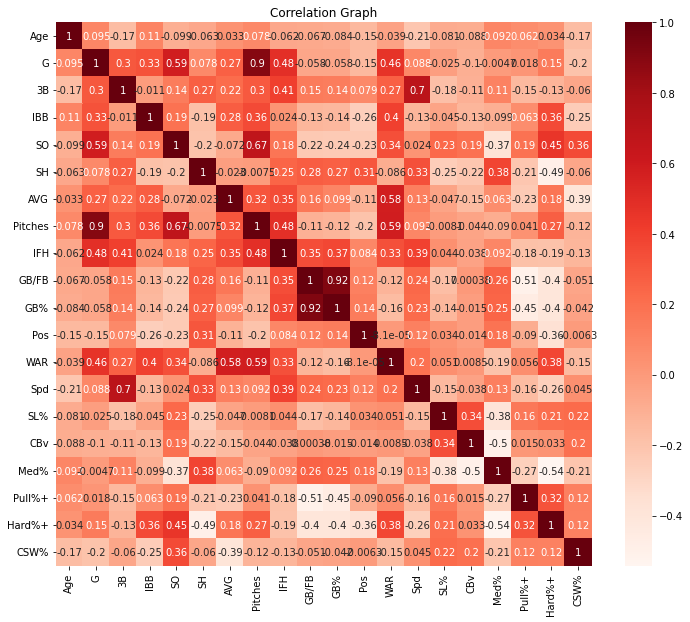

In [ ]:
plt.figure(figsize = (12, 10))
cor = baseballData[predictors].corr()
sb.heatmap(cor, annot = True, cmap = plt.cm.Reds)
plt.title("Correlation Graph")
plt.show()

In [ ]:
sb.pairplot(baseballData[predictors], hue = "gender")